In [1]:
#Matthew Dobbin
#Summer 2018 Final Project
#DrivenData: Boxplots for Education
#Predict454 Advanced Modelling Technniques
#https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/

#This was my first attempt at using Python for predictive modelling. This competetion was chosen as
#it was an opportunity to explore natural language processing. Also available was a Datacamp.com
#tutorial on how to approach the problem in Python. Codes sections for building a logisitic regression
#pipeline that merges numerical and text features from the tutorials have been copied and modified
#to make my own improvements. 
#https://www.datacamp.com/courses/machine-learning-with-the-experts-school-budgets

In [2]:
#Import Training Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import warn

train = pd.read_csv('TrainingData.csv', index_col=0, low_memory=False)
test = pd.read_csv('TestData.csv', index_col=0, low_memory=False)

In [3]:
#Explore Data
#train.head()
#train.info()
#train['FTE'].describe()
#train['Total'].describe()

                 FTE         Total
count  126071.000000  3.957220e+05
mean        0.426794  1.310586e+04
std         0.573576  3.682254e+05
min        -0.087551 -8.746631e+07
25%         0.000792  7.379770e+01
50%         0.130927  4.612300e+02
75%         1.000000  3.652662e+03
max        46.800000  1.297000e+08


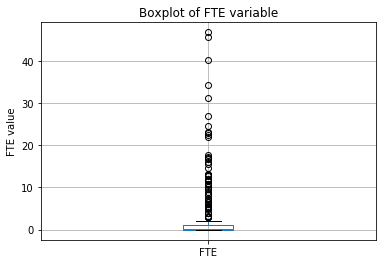

In [4]:
#Numerical Exploratory Data Analysis
#Two numerical variables (FTE and Total)
#View summary statistics
print(train.describe())

#View boxplot of FTE
train.boxplot(column='FTE', return_type='axes')
plt.ylabel(("FTE value"))
plt.title("Boxplot of FTE variable")
train.loc[train['FTE'] > 1.2] = np.nan
train.loc[train['FTE'] < 0] = np.nan
test.loc[test['FTE'] > 1.2] = np.nan
test.loc[test['FTE'] < 0] = np.nan

#View boxplot of Total
#train.boxplot(column='Total', return_type='axes')
#plt.ylabel(("Total value"))
#plt.title("Boxplot of Total variable")

#Set reasonable cutoffs, although hard to determine what is reasonable. I would like to attend a 
#school that has a 100,000,000 budget.
train.loc[train['Total'] > 1000000] = np.nan
train.loc[train['Total'] < -1000000] = np.nan
test.loc[test['Total'] > 1000000] = np.nan
test.loc[test['Total'] < -1000000] = np.nan

#Numeric data list variable for pipeline
NUMERIC_COLUMNS = ['FTE', 'Total']

In [5]:
#Categorial Exploratory Data Analysis
#Convert the nine label columns of object type to category
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']
train[LABELS].dtypes
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')
# Convert train[LABELS] to a categorical type
train[LABELS] = train[LABELS].apply(categorize_label, axis=0)
train[LABELS].dtypes

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object

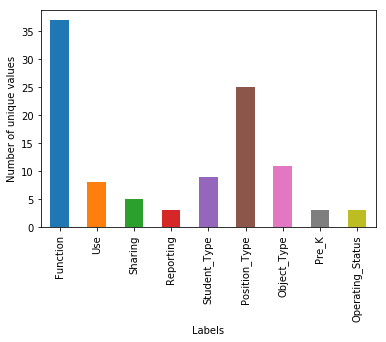

In [6]:
#Create a plot of the number of unique labels for each label.
num_unique_labels = train[LABELS].apply(pd.Series.nunique)
num_unique_labels.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.show()

In [7]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

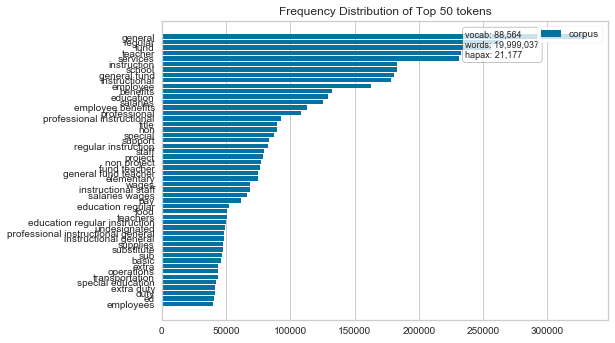

In [122]:
#http://www.scikit-yb.org/en/latest/api/text/freqdist.html
#Create a plot showing frequency distribution of top 50 tokens
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
df = combine_text_columns(train, to_drop=NUMERIC_COLUMNS + LABELS)
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 3))
docs       = vectorizer.fit_transform(df.values)
features   = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
plt.title('Frequency Distribution of Top 50 tokens')

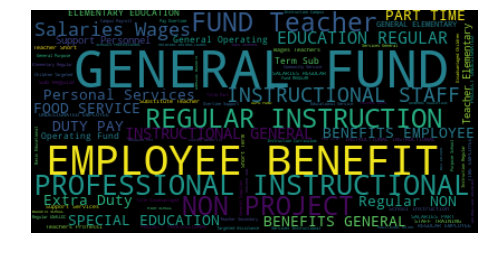

In [123]:
#Create a word cloud.
from wordcloud import WordCloud
cloud_df = df.to_frame()
cloud_df.columns = ['text']

#Join all the rows:
cloudtext = " ".join(row for row in cloud_df.text)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(cloudtext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# Code for multilable_sample function obtained from 
#https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [9]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [10]:
# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(train[LABELS])

# Get the columns that are features in the training data frame
NON_LABELS = [c for c in train.columns if c not in LABELS]

# Split into training and test sets using the multilable train test split function.
X_train, X_test, y_train, y_test = multilabel_train_test_split(train[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

In [11]:
#My attempt to calculate log loss for validation test set based on the competition multi multi log loss formula. 
def return_log_loss(valid_df):
    #Log Loss parameters for validation test set.
    N=80055.0
    K=9.0
    ll_function =0 
    ll_use = 0
    ll_sharing=0
    ll_reporting=0
    ll_student=0
    ll_position=0
    ll_object=0
    ll_pre=0
    ll_operating=0

    for i in range(0,80055):
        for j in range(0,36):
            ll_function = ll_function + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_function = -1*ll_function/N

    for i in range(0,80055):
        for j in range(37,44):
            ll_use = ll_use + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_use = -1*ll_use/N
        
    for i in range(0,80055):
        for j in range(45,49):
            ll_sharing = ll_sharing + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_sharing = -1*ll_sharing/N        
    
    for i in range(0,80055):
        for j in range(50,52):
            ll_reporting = ll_reporting + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_reporting = -1*ll_reporting/N           
    
    for i in range(0,80055):
        for j in range(53,61):
            ll_student = ll_student + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_student = -1*ll_student/N           

    for i in range(0,80055):
        for j in range(62,86):
            ll_position = ll_position +  y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_position = -1*ll_position/N         

    for i in range(0,80055):
        for j in range(87,97):
            ll_object = ll_object + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_object = -1*ll_object/N         

    for i in range(0,80055):
        for j in range(98,100):
            ll_pre = ll_pre +  y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_pre = -1*ll_pre/N         

    for i in range(0,80055):
        for j in range(101,103):
            ll_operating = ll_operating + y_test.iloc[i,j]*np.log(valid_df.iloc[i,j])
    ll_operating = -1*ll_operating/N 

    logloss = (ll_function + ll_use + ll_sharing + ll_reporting + ll_student + ll_position + ll_object + ll_pre + ll_operating)/K
    return(logloss)

In [135]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 1000 best features
chi_k = 1000

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

#Start computational clock
import time
time_start=time.clock()

# Instantiate pipeline: pl
lpl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 1))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])
# Fit to the training data
lpl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = lpl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for Logistic Regression was:")
print("%d:%02d:%02d" % (h, m, s))


Accuracy on budget dataset:  0.8172506401848729

Computational time for Logistic Regression was:
0:10:30


In [132]:
#Determine which text features were selected by working way through pipeline.
feature_names = lpl.named_steps['union'].transformer_list[1][1].named_steps['vectorizer'].get_feature_names()
mask = lpl.named_steps['union'].transformer_list[1][1].named_steps['dim_red'].get_support()

#Create a list with the best chi_k selected features appended to the two numerical features.
best_features = ['FTE', 'Total']
for bool, feature in zip(mask, feature_names):
    if bool:
        best_features.append(feature)

#Create a dataframe with features and logistic regression coefficients. Export to csv.
coefficients = lpl.named_steps['clf'].coef_
coefficients = pd.DataFrame(list(coefficients))
coefficients = coefficients.transpose()
coefficients.columns = pd.get_dummies(train[LABELS],prefix_sep='__').columns
coeffinal = pd.DataFrame(best_features)
coeffinal = pd.concat([coeffinal, coefficients], axis=1)
coeffinal.to_csv('Logistic_Coefficents.csv')

In [136]:
#Logistic Predictions on validation set
valid = lpl.predict_proba(X_test)
valid_df = pd.DataFrame(columns=pd.get_dummies(train[LABELS],prefix_sep='__').columns,
                             index=X_test.index,
                             data=valid)
valid_df = valid_df.sort_index(axis=1)
ll_logloss = return_log_loss(valid_df)
print("Validation test set log loss for Logistic model was ", ll_logloss)

Validation test set log loss for Logistic model was  4.897430647827139


In [137]:
#Logistic Predictions on Test Set
predictions = lpl.predict_proba(test)
prediction_df = pd.DataFrame(columns=pd.get_dummies(train[LABELS],prefix_sep='__').columns,
                             index=test.index,
                             data=predictions)
prediction_df = prediction_df.sort_index(axis=1)
prediction_df.to_csv('Logistic_Predictions.csv')

   Features  Accuracy  Log Loss
0        50     0.327    0.9212
1       300     0.650    0.7558
2      1000     0.792    0.6359
3      2000     0.817    0.6407
4      3000     0.817    0.6387


Text(0,0.5,'Log Loss')

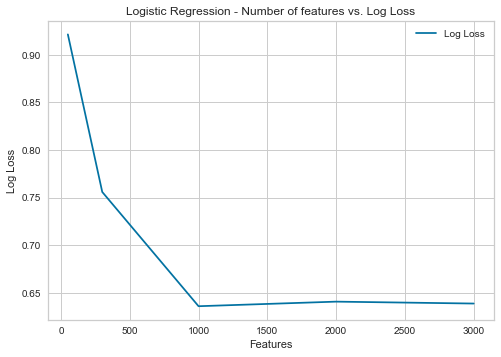

In [138]:
#Create a dataframe to store results from manual trials
data = [[50, 0.327, 0.9212],[300, 0.65, 0.7558], [1000, 0.792, 0.6359],[2000, 0.817, 0.6407 ],[3000, 0.817, 0.6387]]
df = pd.DataFrame(data,columns=['Features', 'Accuracy', 'Log Loss'])
print(df)

#Create a plot of number of features vs. log loss
df.plot(x='Features', y='Log Loss')
plt.title('Logistic Regression - Number of features vs. Log Loss')
plt.ylabel('Log Loss')

In [38]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

#Start computational clock
import time
time_start=time.clock()

# Instantiate pipeline: pl
dtpl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   non_negative=True, norm=None, binary=False,
                                                   ngram_range=(1, 1))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', DecisionTreeClassifier(random_state=0))
    ])
# Fit to the training data
dtpl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = dtpl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for Decision Tree was:")
print("%d:%02d:%02d" % (h, m, s))

C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)



Accuracy on budget dataset:  0.9144713009805758

Computational time for Decision Tree was:
0:02:24


In [47]:
#Decision Tree Predictions
predictions = dtpl.predict_proba(test)
predictions = np.array(predictions)
predictions = predictions[:,:,1]
predictions = predictions.transpose()
prediction_df = pd.DataFrame(columns=pd.get_dummies(train[LABELS],prefix_sep='__').columns,
                             index=test.index,
                             data=predictions)
prediction_df = prediction_df.sort_index(axis=1)
prediction_df.to_csv('DecisionTree_predictions.csv')

C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier 

time_start=time.clock()
# Instantiate pipeline: pl
rfpl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   non_negative=True, norm=None, binary=False,
                                                   ngram_range=(1, 1)))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf',  RandomForestClassifier(random_state=0))
    ])

# Fit to the training data
rfpl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = rfpl.score(X_test, y_test)
seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nAccuracy on budget dataset: ", accuracy)
print("\nComputational time for Random Forest was:")
print("%d:%02d:%02d" % (h, m, s))

In [ ]:
#Random Forest Predictions
predictions = rfpl.predict_proba(test)
predictions = np.array(predictions)
print(predictions.shape)
predictions = predictions[:,:,1]
predictions = predictions.transpose()
prediction_df = pd.DataFrame(columns=pd.get_dummies(train[LABELS],prefix_sep='__').columns,
                             index=test.index,
                             data=predictions)
prediction_df = prediction_df.sort_index(axis=1)
prediction_df.to_csv('RandomForest_predictions.csv')

In [149]:
#Random Forest with Grid Search
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
chi_k = 1000

# Use a grid over parameters of interest
param_grid = {'clf__n_estimators' : [50, 100],
             'clf__max_depth' : [5, 10],
              'clf__min_samples_leaf' : [5, 10]}

time_start=time.clock()
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   non_negative=True, norm=None, binary=False,
                                                   ngram_range=(1, 1)))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf',  RandomForestClassifier())
    ])

g_search = GridSearchCV(pl, param_grid, cv = 5)

# Fit to the training data
g_fit = g_search.fit(X_train, y_train)

# Get the best estimator
best_rf = g_fit.best_estimator_
best_param = g_fit.best_params_
print(best_param)

# Compute and print accuracy
accuracy = best_rf.score(X_test, y_test)
seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nAccuracy on budget dataset: ", accuracy)
print("\nComputational time for Random Forest grid search was:")
print("%d:%02d:%02d" % (h, m, s))
    
 

C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\sit

C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
C:\Users\mkdob\Anaconda3\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


KeyboardInterrupt: 

In [ ]:
#View feature importance from best random forest model
feature_names = best_rf.named_steps['union'].transformer_list[1][1].named_steps['vectorizer'].get_feature_names()
mask = best_rf.named_steps['union'].transformer_list[1][1].named_steps['dim_red'].get_support()

#Create a list with the best chi_k selected features appended to the two numerical features.
best_features = ['FTE', 'Total']
for bool, feature in zip(mask, feature_names):
    if bool:
        best_features.append(feature)
        
View a list of the features and their importance scores
list(zip(best_features, best_rf.feature_importances))

In [ ]:
#Random Forest Predictions
predictions = best_rf.predict_proba(test)
predictions = np.array(predictions)
print(predictions.shape)
predictions = predictions[:,:,1]
predictions = predictions.transpose()
prediction_df = pd.DataFrame(columns=pd.get_dummies(train[LABELS],prefix_sep='__').columns,
                             index=test.index,
                             data=predictions)
prediction_df = prediction_df.sort_index(axis=1)
prediction_df.to_csv('RandomForest_GridSearch_predictions.csv')

In [ ]:
#k nearest neighbours - Attempted to fit KNeighbors classifier but I was unable to resolve errors.
from sklearn.neighbors import KNeighborsClassifier

#Start computational clock
import time
time_start=time.clock()

# Instantiate pipeline: pl
knpl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   non_negative=True, norm=None, binary=False,
                                                   ngram_range=(1, 1))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10)))
    ])

# Fit to the training data
knpl.fit(X_train, y_train)

# 
accuracy = knpl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nComputational time for k-nearest-neighbor was:")
print("%d:%02d:%02d" % (h, m, s))

#k nearest neighbor predictions
predictions = knpl.predict_proba(test)
predictions = np.array(predictions)
prediction_df = pd.DataFrame(columns=pd.get_dummies(train[LABELS],prefix_sep='__').columns,
                             index=test.index,
                             data=predictions)
prediction_df = prediction_df.sort_index(axis=1)
prediction_df.to_csv('knn_predictions.csv')


In [12]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 1000 best features
chi_k = 5

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

#Neural Net Model - An attempt to fit a sequential neural network was made however I was unable to work out the correct code.
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
time_start=time.clock()

n_pred = 2 + chi_k

def create_model(n_cols):
    model = Sequential()
    model.add(Dense(64,activation='relu', input_shape= (n_pred,)))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(104,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

# wrap the model 
clf = KerasClassifier(build_fn=create_model(n_pred))

# Instantiate pipeline: pl
nnpl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   non_negative=True, norm=None, binary=False,
                                                   ngram_range=(1, 2)))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf',  clf)
    ])

# Fit to the training data
nnpl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = nnpl.score(X_test, y_test)
seconds = (time.clock() - time_start)
m, s = divmod(seconds, 60)
h, m = divmod(m, 60)
print("\nAccuracy on budget dataset: ", accuracy)
print("\nComputational time for Neural Net was:")
print("%d:%02d:%02d" % (h, m, s))                          

ModuleNotFoundError: No module named 'tensorflow'